# Preventing Overfitting
Deep Learning - KI29  
Deggendorf Institute of Technology  
Prof. Dr. Florian Wahl

## Existierende Codebase

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nnfs
from nnfs.datasets import spiral_data

In [3]:
# Dense Layer
class Layer_Dense:

    # Initialization Code
    def __init__(self, n_inputs, n_neurons):
        # Initilalize weights and biases according to the shape given
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs

        # Calculate output as we did on the slides
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [4]:
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs

        # Calculate the output based on inputs.
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        # Copy before we modify
        self.dinputs = dvalues.copy()

        # Set to 0 if value is <=0
        self.dinputs[self.inputs <= 0] = 0

In [5]:
class Loss:
    def calculate(self, output, y):
        # Calculate the per sample loss
        samples_losses = self.forward(output, y)

        # Calculate the mean loss and return it
        loss = np.mean(samples_losses)
        return loss

In [6]:
# Softmax activation
class Activation_Softmax:
    def forward(self, inputs):
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        # Normalize them for each sample
        self.output = probabilities

    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(
            zip(self.output, dvalues)
        ):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(
                single_output, single_output.T
            )

            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [21]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy:
    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):  # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded, # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [8]:
# SGD optimizer
class Optimizer_SGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1.0, decay=0.0, momentum=0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
            )

    # Update parameters
    def update_params(self, layer):
        if self.momentum:
            # If layer has no momentum arrays, create them
            if not hasattr(layer, "weight_momentums"):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Compute weight updates
            weight_updates = (
                self.momentum * layer.weight_momentums
                - self.current_learning_rate * layer.dweights
            )
            layer.weight_momentums = weight_updates

            # Compute bias updates
            bias_updates = (
                self.momentum * layer.bias_momentums
                - self.current_learning_rate * layer.dbiases
            )
            layer.bias_momentums = bias_updates

        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        # Perform update
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

In [9]:
class Optimizer_Adagrad:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1.0, decay=0.0, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
            )

    # Update parameters
    def update_params(self, layer):
        # If layer has no cache arrays, create them
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update the cache
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Compute weight updates
        layer.weights += (
            -self.current_learning_rate
            * layer.dweights
            / (np.sqrt(layer.weight_cache) + self.epsilon)
        )

        # Compute bias updates
        layer.biases += (
            -self.current_learning_rate
            * layer.dbiases
            / (np.sqrt(layer.bias_cache) + self.epsilon)
        )

    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

In [10]:
class Optimizer_RMSprop:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1.0, decay=0.0, epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
            )

    # Update parameters
    def update_params(self, layer):
        # If layer has no cache arrays, create them
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update the cache
        layer.weight_cache = (
            self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        )
        layer.bias_cache = (
            self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2
        )

        # Compute weight updates
        layer.weights += (
            -self.current_learning_rate
            * layer.dweights
            / (np.sqrt(layer.weight_cache) + self.epsilon)
        )

        # Compute bias updates
        layer.biases += (
            -self.current_learning_rate
            * layer.dbiases
            / (np.sqrt(layer.bias_cache) + self.epsilon)
        )

    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

In [11]:
class Optimizer_Adam:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=0.001, decay=0.0, epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
            )

    # Update parameters
    def update_params(self, layer):
        # If layer has no cache arrays, create them
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            layer.bias_momentums = np.zeros_like(layer.biases)
            
        # Compute momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # Perform momentum correction using beta 1 (add +1 to avoid zero-division error)
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update the cache
        layer.weight_cache = (
            self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        )
        layer.bias_cache = (
            self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        )
        
        # Perform cache correction
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Compute weight updates
        layer.weights += (
            -self.current_learning_rate
            * weight_momentums_corrected
            / (np.sqrt(weight_cache_corrected) + self.epsilon)
        )

        # Compute bias updates
        layer.biases += (
            -self.current_learning_rate
            * bias_momentums_corrected
            / (np.sqrt(bias_cache_corrected) + self.epsilon)
        )

    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

## Regularisierung

### Vorgehen
1. $\lambda$ Parameter für L1, L2 Gewichts- und Biasregularisierung zu Dense Layer hinzufügen
2. Berechnung der Regularisierungsstrafen in genereller Loss Klasse einbauen
3. Backward pass in Dense Layer implementieren
4. Regularisierung zu Beispiel hinzufügen

In [12]:
# Dense Layer
class Layer_Dense:

    # Initialization Code
    def __init__(self, n_inputs, n_neurons, 
                 weight_regularizer_l1=0, weight_regularizer_l2=0, 
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initilalize weights and biases according to the shape given
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs):
        self.inputs = inputs

        # Calculate output as we did on the slides
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Regularization
        # L1 weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1

        # L1 biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1

        # L2 weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights

        # L2 biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
            

        # Gradients on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [19]:
class Loss:
    def calculate(self, output, y):
        # Calculate the per sample loss
        samples_losses = self.forward(output, y)

        # Calculate the mean loss and return it
        loss = np.mean(samples_losses)
        return loss

    def regularization_loss(self, layer):
        regularization_loss = 0

        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights ** 2)

        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases ** 2)

        return regularization_loss

In [20]:
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        n_samples = len(y_pred)  # Count the samples

        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip the predictions

        # Get correct confidence values
        # if labels are sparse
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(n_samples), y_true]

        # else if labels are one hot encoded
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        # Compute Losses
        losses = -np.log(correct_confidences)
        return losses

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)

        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues

        # Normalize gradient
        self.dinputs = self.dinputs / samples

lr: 0.02, epoch: 0, acc: 0.350, loss: 1.099
lr: 0.02, epoch: 1000, acc: 0.923, loss: 0.182
lr: 0.02, epoch: 2000, acc: 0.940, loss: 0.133
lr: 0.02, epoch: 3000, acc: 0.960, loss: 0.100
lr: 0.02, epoch: 4000, acc: 0.967, loss: 0.080
lr: 0.02, epoch: 5000, acc: 0.973, loss: 0.072
lr: 0.02, epoch: 6000, acc: 0.980, loss: 0.067
lr: 0.02, epoch: 7000, acc: 0.983, loss: 0.059
lr: 0.02, epoch: 8000, acc: 0.983, loss: 0.056
lr: 0.02, epoch: 9000, acc: 0.970, loss: 0.078
lr: 0.02, epoch: 10000, acc: 0.980, loss: 0.054
Validation Loss: 1.232, Validation Accuracy: 0.807.


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

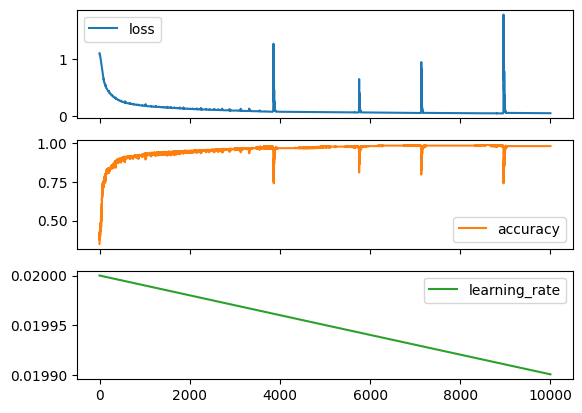

In [28]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 512)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(512, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer

optimizer = Optimizer_Adam(learning_rate=0.02, decay=5e-7)

losses = []
accuracies = []
learning_rates = []

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)

    # Calculate accuracy from output of activation2 and targets # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 1000:
        print(
            f"lr: {round(optimizer.current_learning_rate, 3)}, "
            + f"epoch: {epoch}, "
            + f"acc: {accuracy:.3f}, "
            + f"loss: {loss:.3f}"
        )
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    losses.append(loss)
    accuracies.append(accuracy)
    learning_rates.append(optimizer.current_learning_rate)

X_test, y_test = spiral_data(samples=100, classes=3)

# Perform a forward pass of our training data through this layer
dense1.forward(X_test)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y_test)

# Calculate accuracy from output of activation2 and targets # calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)
print(f"Validation Loss: {round(loss, 3)}, Validation Accuracy: {round(accuracy, 3)}.")
    

df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

lr: 0.02, epoch: 0, acc: 0.350, data_loss: 1.099, reg_loss: 0.000, loss: 1.099
lr: 0.02, epoch: 1000, acc: 0.873, data_loss: 0.346, reg_loss: 0.101, loss: 0.447
lr: 0.02, epoch: 2000, acc: 0.903, data_loss: 0.270, reg_loss: 0.087, loss: 0.357
lr: 0.02, epoch: 3000, acc: 0.907, data_loss: 0.241, reg_loss: 0.077, loss: 0.318
lr: 0.02, epoch: 4000, acc: 0.917, data_loss: 0.222, reg_loss: 0.069, loss: 0.292
lr: 0.02, epoch: 5000, acc: 0.920, data_loss: 0.210, reg_loss: 0.064, loss: 0.274
lr: 0.02, epoch: 6000, acc: 0.913, data_loss: 0.207, reg_loss: 0.064, loss: 0.270
lr: 0.02, epoch: 7000, acc: 0.917, data_loss: 0.198, reg_loss: 0.059, loss: 0.257
lr: 0.02, epoch: 8000, acc: 0.917, data_loss: 0.193, reg_loss: 0.055, loss: 0.248
lr: 0.02, epoch: 9000, acc: 0.920, data_loss: 0.187, reg_loss: 0.058, loss: 0.245
lr: 0.02, epoch: 10000, acc: 0.933, data_loss: 0.178, reg_loss: 0.054, loss: 0.232
Validation Loss: 0.567, Validation Accuracy: 0.847.


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

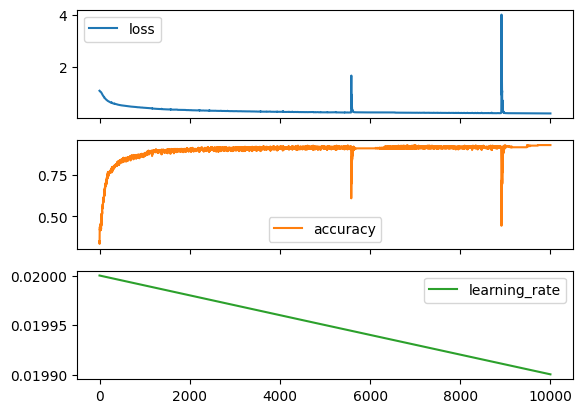

In [25]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer

optimizer = Optimizer_Adam(learning_rate=0.02, decay=5e-7)

losses = []
accuracies = []
learning_rates = []

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    data_loss = loss_activation.forward(dense2.output, y)

    regularization_loss = loss_activation.loss.regularization_loss(dense1) + \
                          loss_activation.loss.regularization_loss(dense2)

    loss = data_loss + regularization_loss

    # Calculate accuracy from output of activation2 and targets # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 1000:
        print(
            f"lr: {round(optimizer.current_learning_rate, 3)}, "
            + f"epoch: {epoch}, "
            + f"acc: {accuracy:.3f}, "
            + f"data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f}, "
            + f"loss: {loss:.3f}"
        )
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    losses.append(loss)
    accuracies.append(accuracy)
    learning_rates.append(optimizer.current_learning_rate)

X_test, y_test = spiral_data(samples=100, classes=3)

# Perform a forward pass of our training data through this layer
dense1.forward(X_test)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y_test)

# Calculate accuracy from output of activation2 and targets # calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)
print(f"Validation Loss: {round(loss, 3)}, Validation Accuracy: {round(accuracy, 3)}.")
    

df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

lr: 0.02, epoch: 0, acc: 0.347, data_loss: 1.099, reg_loss: 0.000, loss: 1.099
lr: 0.02, epoch: 1000, acc: 0.927, data_loss: 0.205, reg_loss: 0.090, loss: 0.295
lr: 0.02, epoch: 2000, acc: 0.937, data_loss: 0.174, reg_loss: 0.087, loss: 0.261
lr: 0.02, epoch: 3000, acc: 0.947, data_loss: 0.155, reg_loss: 0.068, loss: 0.223
lr: 0.02, epoch: 4000, acc: 0.953, data_loss: 0.145, reg_loss: 0.062, loss: 0.207
lr: 0.02, epoch: 5000, acc: 0.950, data_loss: 0.139, reg_loss: 0.065, loss: 0.204
lr: 0.02, epoch: 6000, acc: 0.950, data_loss: 0.133, reg_loss: 0.055, loss: 0.188
lr: 0.02, epoch: 7000, acc: 0.940, data_loss: 0.134, reg_loss: 0.059, loss: 0.193
lr: 0.02, epoch: 8000, acc: 0.577, data_loss: 3.507, reg_loss: 0.053, loss: 3.560
lr: 0.02, epoch: 9000, acc: 0.947, data_loss: 0.128, reg_loss: 0.054, loss: 0.182
lr: 0.02, epoch: 10000, acc: 0.943, data_loss: 0.125, reg_loss: 0.052, loss: 0.177
Validation Loss: 0.44, Validation Accuracy: 0.867.


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

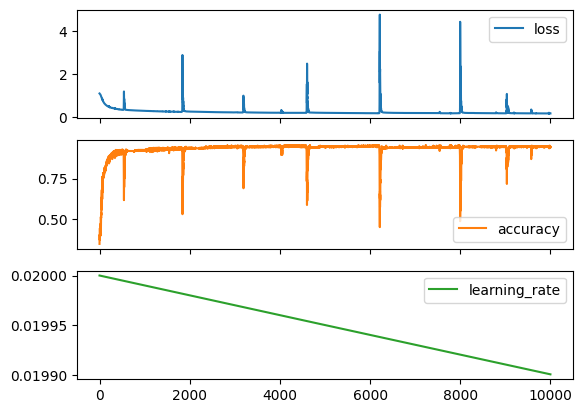

In [26]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 512, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(512, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer

optimizer = Optimizer_Adam(learning_rate=0.02, decay=5e-7)

losses = []
accuracies = []
learning_rates = []

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    data_loss = loss_activation.forward(dense2.output, y)

    regularization_loss = loss_activation.loss.regularization_loss(dense1) + \
                          loss_activation.loss.regularization_loss(dense2)

    loss = data_loss + regularization_loss

    # Calculate accuracy from output of activation2 and targets # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 1000:
        print(
            f"lr: {round(optimizer.current_learning_rate, 3)}, "
            + f"epoch: {epoch}, "
            + f"acc: {accuracy:.3f}, "
            + f"data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f}, "
            + f"loss: {loss:.3f}"
        )
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    losses.append(loss)
    accuracies.append(accuracy)
    learning_rates.append(optimizer.current_learning_rate)

X_test, y_test = spiral_data(samples=100, classes=3)

# Perform a forward pass of our training data through this layer
dense1.forward(X_test)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y_test)

# Calculate accuracy from output of activation2 and targets # calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)
print(f"Validation Loss: {round(loss, 3)}, Validation Accuracy: {round(accuracy, 3)}.")
    

df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

## Dropout
### Vorgehen
1. Bernoulli Verteilung mit numpy realisieren
2. Dropout Layer implementieren
3. Dropout in Beispiel einbauen

Binomialverteilung ist Bernoulli mit mehreren Runden. Daher ist Bernoulli das gleiche wie Binomial mit einem Experiment.

In [41]:
dropout = 0.2
outputs = np.array([.27, -1.02, .67, .99, .05, .27, -12, .67, .33])

r = np.random.binomial(1, 1-dropout, size=outputs.shape)

r*outputs

array([  0.27,  -0.  ,   0.67,   0.99,   0.  ,   0.  , -12.  ,   0.  ,
         0.33])

In [46]:
class Layer_Dropout:
    def __init__(self, rate):
        # Store the dropout probability which is 1-dropout_rate
        self.rate = 1 - rate
        
    def forward(self, inputs):
        # Save inputs
        self.inputs = inputs
        
        # Generate dropout mask
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        
        # Apply output mask
        self.output = inputs * self.binary_mask
        
    def backward(self, dvalues):
        # Apply gradient on values
        self.dinputs = dvalues * self.binary_mask / self.rate

lr: 0.02, epoch: 0, acc: 0.313, data_loss: 1.099, reg_loss: 0.000, loss: 1.099
lr: 0.02, epoch: 1000, acc: 0.858, data_loss: 0.405, reg_loss: 0.090, loss: 0.495
lr: 0.02, epoch: 2000, acc: 0.873, data_loss: 0.356, reg_loss: 0.083, loss: 0.438
lr: 0.02, epoch: 3000, acc: 0.882, data_loss: 0.323, reg_loss: 0.080, loss: 0.403
lr: 0.02, epoch: 4000, acc: 0.878, data_loss: 0.349, reg_loss: 0.077, loss: 0.426
lr: 0.02, epoch: 5000, acc: 0.888, data_loss: 0.318, reg_loss: 0.075, loss: 0.393
lr: 0.02, epoch: 6000, acc: 0.882, data_loss: 0.305, reg_loss: 0.075, loss: 0.379
lr: 0.02, epoch: 7000, acc: 0.875, data_loss: 0.335, reg_loss: 0.073, loss: 0.408
lr: 0.02, epoch: 8000, acc: 0.882, data_loss: 0.338, reg_loss: 0.072, loss: 0.410
lr: 0.02, epoch: 9000, acc: 0.870, data_loss: 0.330, reg_loss: 0.073, loss: 0.403
lr: 0.02, epoch: 10000, acc: 0.880, data_loss: 0.337, reg_loss: 0.072, loss: 0.408
Validation Loss: 0.526, Validation Accuracy: 0.857.


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

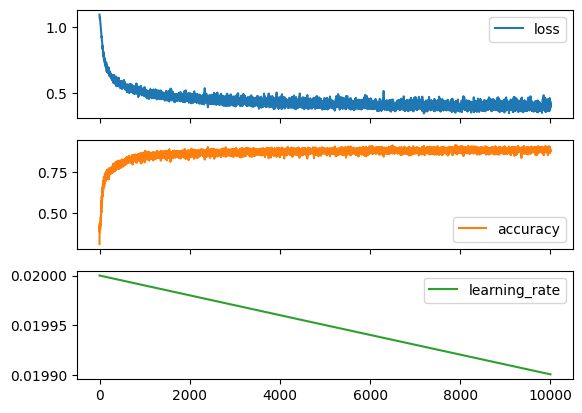

In [47]:
# Create dataset
X, y = spiral_data(samples=200, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 512, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

dropout1 = Layer_Dropout(0.1)

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(512, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer

optimizer = Optimizer_Adam(learning_rate=0.02, decay=5e-7)

losses = []
accuracies = []
learning_rates = []

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    dropout1.forward(activation1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(dropout1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    data_loss = loss_activation.forward(dense2.output, y)

    regularization_loss = loss_activation.loss.regularization_loss(dense1) + \
                          loss_activation.loss.regularization_loss(dense2)

    loss = data_loss + regularization_loss

    # Calculate accuracy from output of activation2 and targets # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 1000:
        print(
            f"lr: {round(optimizer.current_learning_rate, 3)}, "
            + f"epoch: {epoch}, "
            + f"acc: {accuracy:.3f}, "
            + f"data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f}, "
            + f"loss: {loss:.3f}"
        )
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    losses.append(loss)
    accuracies.append(accuracy)
    learning_rates.append(optimizer.current_learning_rate)

X_test, y_test = spiral_data(samples=100, classes=3)

# Perform a forward pass of our training data through this layer
dense1.forward(X_test)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y_test)

# Calculate accuracy from output of activation2 and targets # calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)
print(f"Validation Loss: {round(loss, 3)}, Validation Accuracy: {round(accuracy, 3)}.")
    

df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0: "loss", 1: "accuracy", 2: "learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)